In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (ModelCheckpoint, TensorBoard, ReduceLROnPlateau,
                                        CSVLogger, EarlyStopping)
from tensorflow.keras.layers import (
    Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, Add, Flatten, Dense)
from tensorflow.keras.models import Model
import datetime
import pandas as pd
import pickle
import demo_model
import numpy as np
import matplotlib.pyplot as plt
import draw_aucs
import seaborn as sns
model_name = "demo_model"

2023-04-06 14:42:29.488979: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# load demo data

In [2]:
demo_agesex_features = pd.read_csv("demo_data/demo_asfeats.csv") # ecgId (used for path) + tabular features 
demo_ecgs = ["ecg_%d"%i for i in range(len(demo_agesex_features))] # paths to ecg files, assuming they're numpy arrays
demo_labels = pd.read_csv("demo_data/demo_labels.csv",index_col=0) 

# Create generators and train

In [3]:

training_generator = demo_model.DataGenerator(demo_ecgs, demo_labels,n_classes=demo_labels.shape[1],age_sex=demo_agesex_features,batch_size=1)
validation_generator = demo_model.DataGenerator(demo_ecgs, demo_labels,n_classes=demo_labels.shape[1],age_sex=demo_agesex_features,batch_size=1)

In [ ]:
loss = 'binary_crossentropy'
lr = 0.005
batch_size = 64
opt = Adam(lr)
callbacks = [ReduceLROnPlateau(monitor='val_loss',
                               factor=0.05,
                               patience=2,
                               min_lr=lr / 100),
             EarlyStopping(patience=5,min_delta=0.00001)]
METRICS = [
      keras.metrics.AUC(multi_label=True,),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = demo_model.get_model_agsx(demo_labels.shape[1])
model.compile(loss=loss, optimizer=opt, metrics=METRICS)

# Save the BEST model
callbacks += [ModelCheckpoint('./models/demo/%s'%model_name, save_best_only=True)]
model.fit(x= training_generator,
                    validation_data=validation_generator,
                     epochs=70,
                    callbacks=callbacks,
                    workers=1)

# Demo plots

In [5]:
# train set probs
yt_list = []
yp_list = []
ecg_list = []
for i in range(len(training_generator)):
        print(i,end="\r")
        yt_list.append(training_generator[i][1])
        yp_list.append(model.predict(training_generator[i][0]))
        # ecg_list.append(training_generator[i][2])
        
y_test = np.concatenate(yt_list)
y_prob = np.concatenate(yp_list)
# ecg_names = np.concatenate(ecg_list)
# pd.DataFrame(data=y_prob,columns=label_df.columns).to_csv("csvs/cutoff_dfs/%s_holdout_train.csv"%MODEL_NAME)
df = pd.DataFrame(data=y_prob,columns=demo_labels.columns)

In [6]:
df = pd.DataFrame(data=y_prob,columns=demo_labels.columns)
# df.index = demo_labels.index
df = df.where(df>0.5,0)
df = df.where(df<=0.5,1)
df

,Non-ST_elevation_(NSTEMI)_myocardial_infarction,ST_elevation_(STEMI)_myocardial_infarction,Heart_failure,Unstable_angina,Atrial_fibrillation,Syncope,Ventricular_tachycardia,Cardiac_arrest,Supraventricular_tachycardia,Atrioventricular_block,Pulmonary_embolism,Aortic_Stenosis,Pulmonary_Hypertension,Hypertrophic_Cardiomyopathy,Mitral_Valve_Prolapse,Mitral_Valve_Stenosis,Cardiac_Amyloidosis
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
4,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
96,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
97,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
98,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
_ ,aucs = draw_aucs.draw_aucs(df.to_numpy(),demo_labels.to_numpy(),demo_labels.columns)

In [8]:
aucs_df = pd.DataFrame(aucs).T
aucs_df.columns = aucs_df.iloc[0]
aucs_df = aucs_df[1:].T.reset_index()

,0,1
0,Non-ST_elevation_(NSTEMI)_myocardial_infarction,0.782828
1,Ventricular_tachycardia,0.782828
2,Pulmonary_Hypertension,0.772727
3,Pulmonary_embolism,0.76821
4,Atrial_fibrillation,0.737374
5,Syncope,0.725806
6,Unstable_angina,0.722453
7,Atrioventricular_block,0.696118
8,Supraventricular_tachycardia,0.677521
9,Cardiac_arrest,0.670588


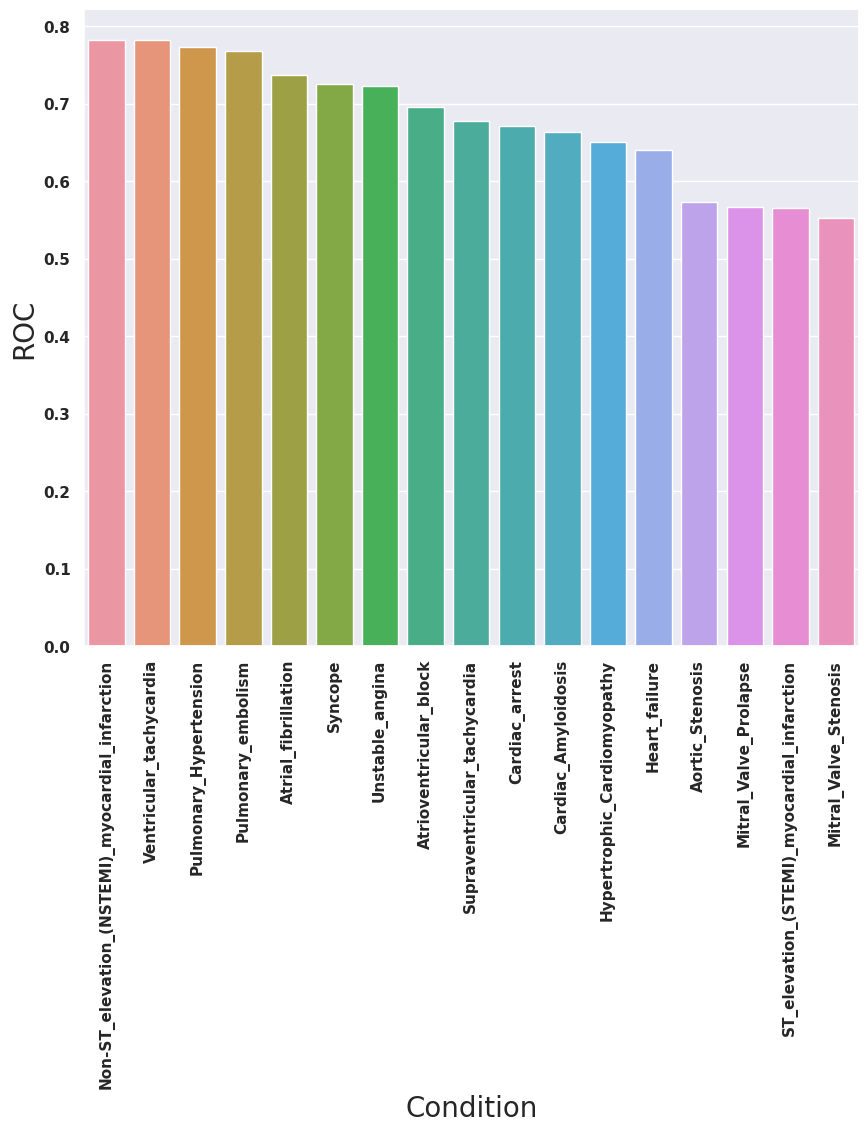

In [9]:
sns.set(rc={'figure.figsize':(10,8.27)})
ax = sns.barplot(x=aucs_df[0],y=aucs_df[1])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_ylabel('ROC',fontsize=20);
ax.set_xlabel('Condition',fontsize=20)
plt.show()